In [7]:
!unzip archive.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [8]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_dir = '/content/train'
test_dir = '/content/test'

In [11]:
train_data_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    horizontal_flip=True
)

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [23]:
# Load Images

train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True
)

test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [24]:
# Map class indices
class_labels = list(train_generator.class_indices.keys())
print("Class Labels:", class_labels)

Class Labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [25]:
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count']).sort_values('Count', ascending=False)

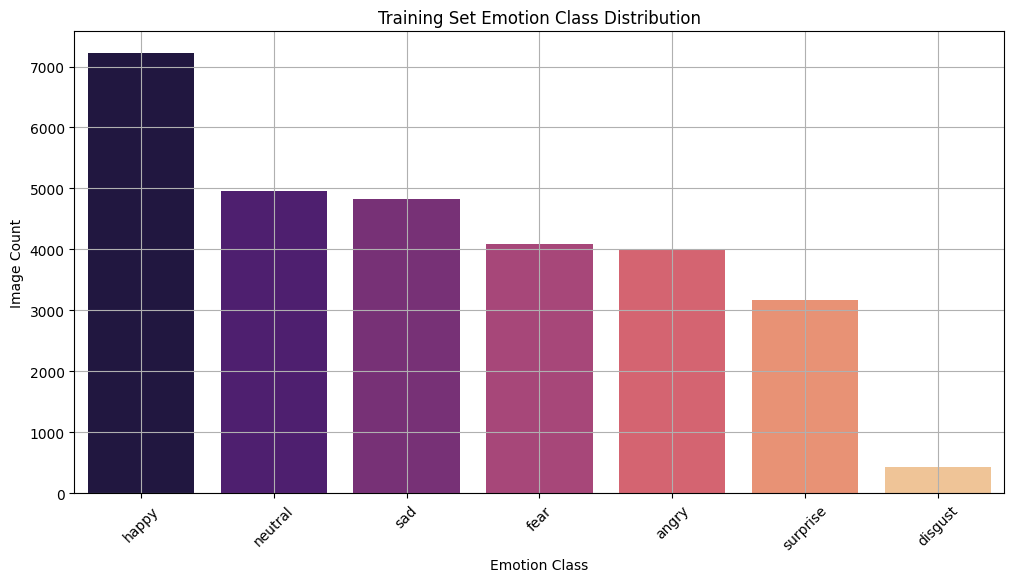

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df.index, y=df['Count'],palette = 'magma')
plt.title('Training Set Emotion Class Distribution')
plt.ylabel('Image Count')
plt.xlabel('Emotion Class')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [34]:
# Handle Class Imbalance

from sklearn.utils.class_weight import compute_class_weight

labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(labels),
    y = labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.0266046844269623), 1: np.float64(9.406618610747051), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


In [35]:
# Build CNN Model

model = Sequential()

model.add(Conv2D(256,kernel_size = (3,3),activation = 'relu',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,kernel_size= (3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,kernel_size= (3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))


model.add(GlobalAveragePooling2D())

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(7,activation = 'softmax'))

In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 2, 2, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,151 (2.25 MB)

 Trainable params: 587,847 (2.24 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [40]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop,reduce_lr]
)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.6220 - loss: 0.9128 - val_accuracy: 0.5963 - val_loss: 1.0674 - learning_rate: 1.2500e-04
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.6291 - loss: 0.9076 - val_accuracy: 0.6000 - val_loss: 1.0785 - learning_rate: 1.2500e-04
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.6286 - loss: 0.9011 - val_accuracy: 0.5965 - val_loss: 1.0731 - learning_rate: 1.2500e-04
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6261 - loss: 0.8956
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.6261 - loss: 0.8957 - val_accuracy: 0.5971 - val_loss: 1.0806 - learning_rate: 1.2500e-04
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.6332 - loss: 0.8945 - val_accuracy: 0.5938 - val_loss: 1.0891 - learning_rate: 6.2500e-05
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - acc

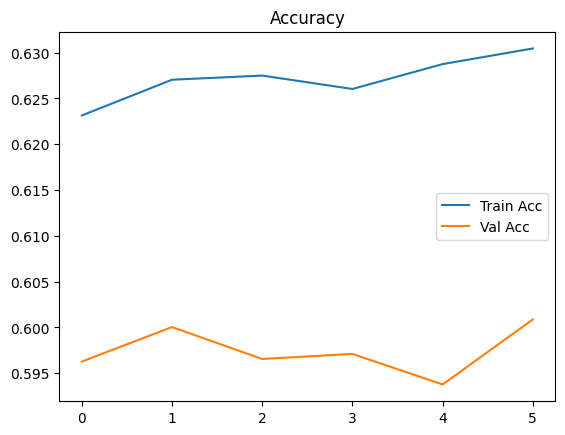

In [41]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

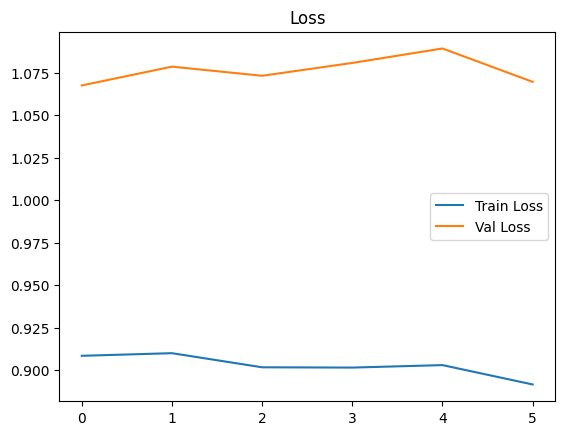

In [42]:
# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [43]:
# Predictions
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


In [44]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.50      0.55      0.53       958
     disgust       0.43      0.66      0.52       111
        fear       0.43      0.31      0.36      1024
       happy       0.86      0.79      0.82      1774
     neutral       0.51      0.64      0.57      1233
         sad       0.48      0.40      0.44      1247
    surprise       0.66      0.80      0.72       831

    accuracy                           0.60      7178
   macro avg       0.55      0.59      0.57      7178
weighted avg       0.60      0.60      0.59      7178



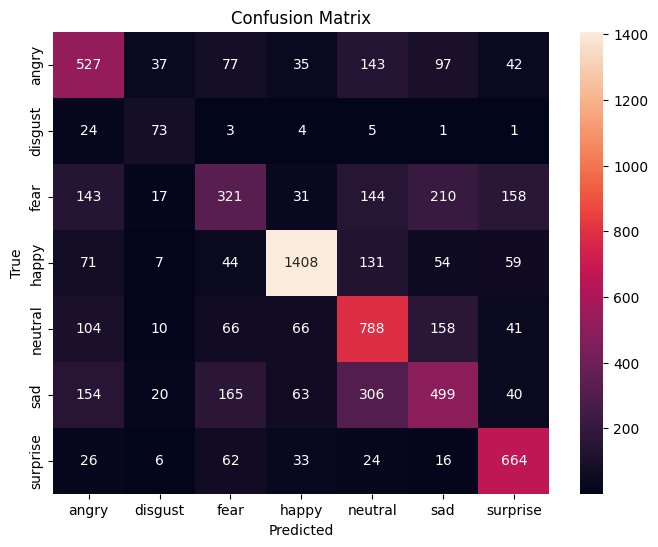

In [45]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [46]:
from tensorflow.keras.preprocessing import image

def predict_emotion(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)
    img_array = img_array.reshape(1, 48, 48, 1) / 255.0
    prediction = model.predict(img_array)
    return class_labels[np.argmax(prediction)]

# ***Prediction 1***

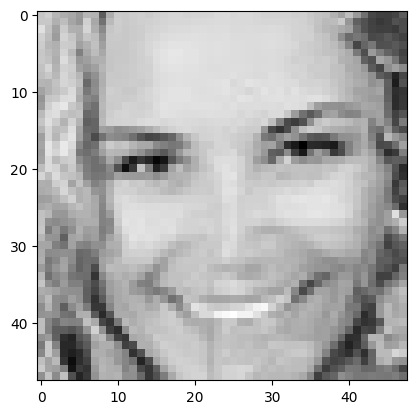


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Emotion Prediction : happy


In [48]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

img_pth = '/content/test/happy/PrivateTest_10077120.jpg'
img = load_img(img_pth, color_mode='grayscale', target_size=(48, 48))

#Image to array
img_array = img_to_array(img)

plt.imshow(img_array.squeeze(), cmap='gray')
plt.show()

print()
print(f'Emotion Prediction : {predict_emotion(img_pth)}')

# ***Prediction 2***

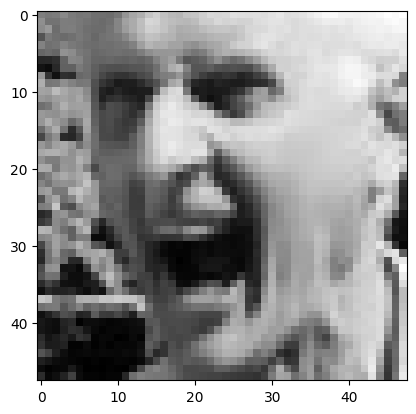


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Emotion Prediction : angry


In [49]:
img_pth = '/content/test/angry/PrivateTest_1109992.jpg'
img = load_img(img_pth, color_mode='grayscale', target_size=(48, 48))

#Image to array
img_array = img_to_array(img)

plt.imshow(img_array.squeeze(), cmap='gray')
plt.show()

print()
print(f'Emotion Prediction : {predict_emotion(img_pth)}')

# ***Prediction 3***

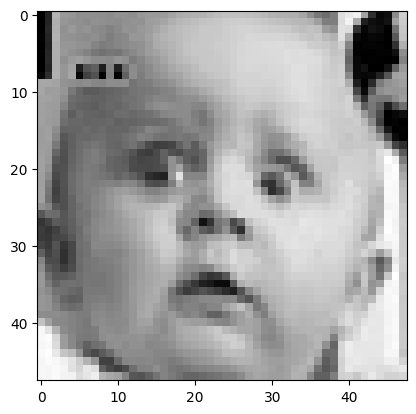


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Emotion Prediction : surprise


In [50]:
img_pth = '/content/test/surprise/PrivateTest_10089743.jpg'
img = load_img(img_pth, color_mode='grayscale', target_size=(48, 48))

#Image to array
img_array = img_to_array(img)

plt.imshow(img_array.squeeze(), cmap='gray')
plt.show()

print()
print(f'Emotion Prediction : {predict_emotion(img_pth)}')

# ***Prediction 4***

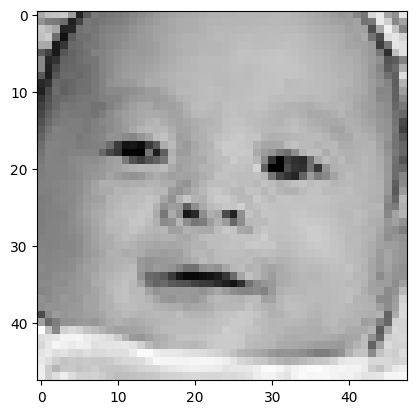


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Emotion Prediction : neutral


In [51]:
img_pth = '/content/test/neutral/PrivateTest_18885324.jpg'
img = load_img(img_pth, color_mode='grayscale', target_size=(48, 48))

#Image to array
img_array = img_to_array(img)

plt.imshow(img_array.squeeze(), cmap='gray')
plt.show()

print()
print(f'Emotion Prediction : {predict_emotion(img_pth)}')

# ***Prediction 5***

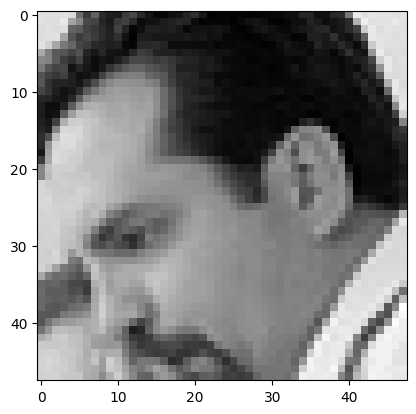


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Emotion Prediction : angry


In [52]:
img_pth = '/content/test/sad/PrivateTest_15444839.jpg'
img = load_img(img_pth, color_mode='grayscale', target_size=(48, 48))

#Image to array
img_array = img_to_array(img)

plt.imshow(img_array.squeeze(), cmap='gray')
plt.show()

print()
print(f'Emotion Prediction : {predict_emotion(img_pth)}')

In [56]:
# Save model

model.save("emotion_model.keras")